In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sklearn.metrics as sm

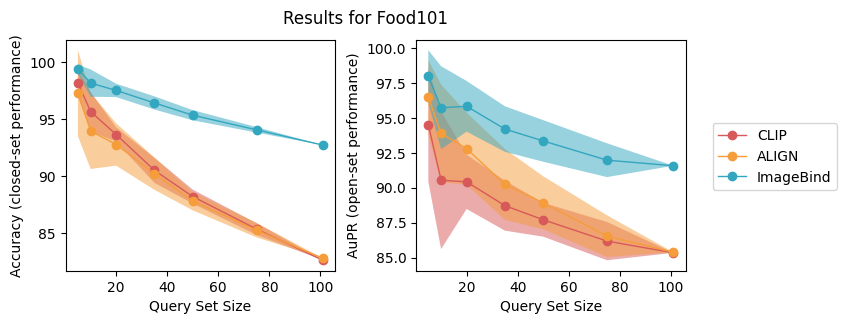

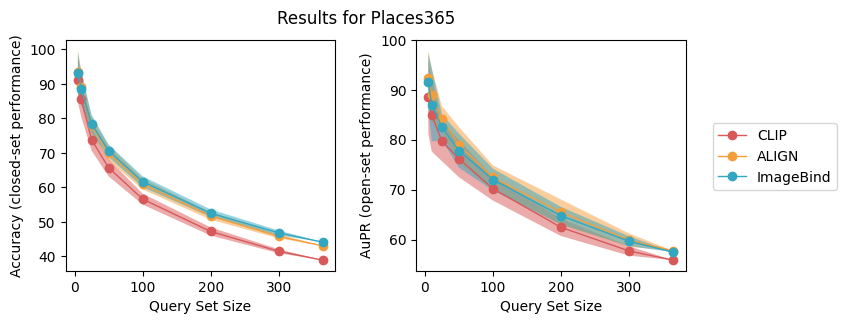

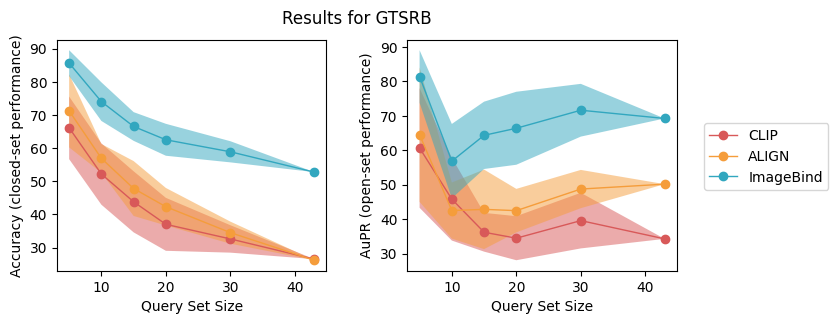

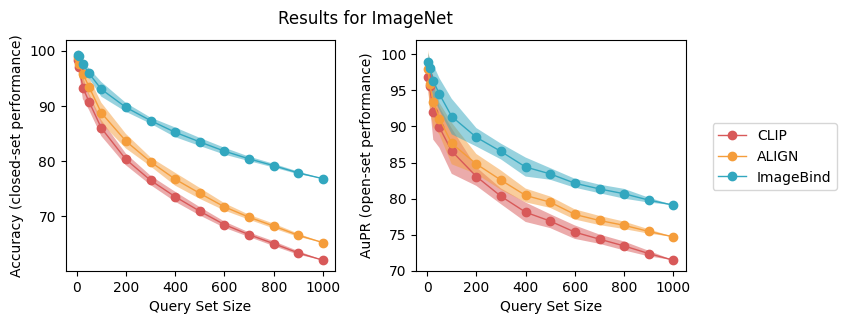

In [2]:
markerTypes = ['X', 'o', '^']
cols = ['#D85959', '#F59D3B', '#32A7BF', '#545154']

modelNames = ['CLIP', 'ALIGN', 'ImageBind']
dataNames = ['Food101', 'Places365', 'GTSRB', 'ImageNet']
data_sizes = {'imagenet': 1000, 'food101': 101, 'places365': 365, 'gtsrb': 43}

for dIdx, dataset in enumerate(['food101', 'places365', 'gtsrb', 'imagenet']):
    seeds = 10
    all_results = {}
    for mIdx, modelType in enumerate(['clip', 'align', 'imagebind']):
        
        num_classes = data_sizes[dataset]
        if dataset == 'imagenet':
            set_sizes = [5, 10, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
        elif dataset == 'food101':
            set_sizes = [5, 10, 20, 35, 50, 75, 101]
        elif dataset == 'places365':
            set_sizes = [5, 10, 25, 50, 100, 200, 300, 365]
        else:
            set_sizes = [5, 10, 15, 20, 30, 43]    
    
        try:
            gt_labels = np.load(f'../pred_files/{modelType}/{dataset}/standard_gt_{modelType}.npy')
            all_cosine = np.load(f'../pred_files/{modelType}/{dataset}/standard_cosine_{modelType}.npy')
        except:
            print(f'No data for {modelType} {dataset}')
            continue
        all_results[modelType] = {'aupr': [], 'acc': []}
        for ss in set_sizes:
            accs = []
            auprs = []
            for seed in range(seeds):
                np.random.seed(seed)
    
                correct_count = 0
                total_count = 0
                
                subset_clses = np.sort(np.random.choice(np.arange(0, num_classes), ss, replace = False))
                
                raw_results = {'softmax': [[], []]}
                for idx in range(len(all_cosine)):
                    target = gt_labels[idx]    
                    #if the image is not in the subset of classes continue (no way to do closed-set test)
                    if np.sum(subset_clses == target) == 0:
                        continue
                        
                    #### Closed-set test
                    cosine = all_cosine[idx]
                    cosine_subset = cosine[subset_clses]
    
                    softmax = scipy.special.softmax(cosine_subset)
                    pred_idx = np.argmax(softmax)
                    pred_score = softmax[pred_idx]
        
                    correct = subset_clses[pred_idx] == target
    
                    if correct:
                        correct_count += 1
                        raw_results['softmax'][0] += [pred_score]    
    
                    total_count += 1
                    
                    ### open-set error test
                    ose_clses = subset_clses[subset_clses != target]
                    cosine_subset_ose = cosine[ose_clses]
                    
                    softmax = scipy.special.softmax(cosine_subset_ose)
                    pred_idx = np.argmax(softmax)
                    pred_score = softmax[pred_idx]
            
                    #Open-set error
                    raw_results['softmax'][1] += [pred_score]
    
        
                for kIdx, k in enumerate(raw_results.keys()):
                    tp = raw_results[k][0]
                    ose = raw_results[k][1]
            
                    acc = correct_count/total_count
                    
                    true = np.concatenate((np.ones(len(tp)), np.zeros(len(ose))))
                    scores = np.concatenate((tp, ose))
        
                    precision, recall, thresholds = sm.precision_recall_curve(true, scores)
                    
                    aupr = sm.auc(recall, precision)
    
                    accs += [acc]
                    auprs += [aupr]
            
                    if ss == num_classes:
                        break #no need to run multiple seeds, no randomness here
    
            all_results[modelType]['acc'] += [[np.mean(accs), np.std(accs)]]
            all_results[modelType]['aupr'] += [[np.mean(auprs), np.std(auprs)]]#
           
    fig, ax = plt.subplots(1, 2, figsize = (8, 3))
    modelNames = ['CLIP', 'ALIGN', 'ImageBind']
    cols = ['#D85959', '#F59D3B', '#32A7BF', '#545154']
    for mIdx, modelType in enumerate(all_results.keys()):
        accs = np.array(all_results[modelType]['acc'])
        if len(accs) == 0:
            continue
        
        acc_mu = 100.*accs[:, 0]
        acc_std = 100.*accs[:, 1]
    
        auprs = np.array(all_results[modelType]['aupr'])
        aupr_mu = 100.*auprs[:, 0]
        aupr_std = 100.*auprs[:, 1]
        ax[0].plot(set_sizes, acc_mu, marker = 'o', lw=1, color=cols[mIdx])
        
        ax[0].fill_between(set_sizes, acc_mu+acc_std, acc_mu-acc_std, facecolor=cols[mIdx], alpha=0.5)
        ax[1].plot(set_sizes, aupr_mu, marker = 'o', lw=1, color=cols[mIdx], label = modelNames[mIdx])
        ax[1].fill_between(set_sizes, aupr_mu+aupr_std, aupr_mu-aupr_std, facecolor=cols[mIdx], alpha=0.5)
        
    ax[0].set_xlabel('Query Set Size')
    ax[0].set_ylabel('Accuracy (closed-set performance)')
    ax[1].set_xlabel('Query Set Size')
    ax[1].set_ylabel('AuPR (open-set performance)')
    ax[1].legend(fontsize = 10, loc = (1.1, 0.35))
    plt.subplots_adjust(wspace = 0.3)
    fig.suptitle(f'Results for {dataNames[dIdx]}')
    plt.savefig(f'../figures/setsize_classification_{dataset}.pdf', bbox_inches = 'tight')
    plt.show()
